In [5]:
import pandas as pd
import numpy as np

In [6]:
financial_data = pd.read_excel('Quarterly Data (with Employees).xlsx')

In [7]:
financial_data_columns = list(financial_data.columns)


In [8]:
quarter_categories = list(financial_data['Fiscal Data Year and Quarter'].unique())
quarter_category_number = np.arange(len(quarter_categories)) + 1
quarter_category_number = quarter_category_number.tolist()

quarter_map = dict(zip(quarter_categories, quarter_category_number))
quarter_map[np.nan] = np.nan

financial_data['time'] = financial_data['Fiscal Data Year and Quarter'].map(quarter_map)

time_col = financial_data.pop('time')
financial_data.insert(2, 'time', time_col)

In [9]:
financial_data['Physical Capital'] = financial_data['Property, Plant and Equipment - Total (Gross)'] + financial_data['Inventories - Total']
financial_data['Non-Physical Capital'] = financial_data['Intangible Assets - Total']
financial_data['PC & NPC'] = financial_data['Physical Capital'] + financial_data['Non-Physical Capital']

In [10]:
identifiers = ['Ticker Symbol',
               'time']

output = ['Revenue - Total']

physical_capital = ['Property, Plant and Equipment - Total (Gross)',
                    'Inventories - Total',
                    'Working Capital (Balance Sheet)']

non_physical_capital = ['Research and Development Expense',
                        'Intangible Assets - Total']

depreciation_cols = ['Depreciation, Depletion and Amortization (Accumulated)',
                     'Depreciation and Amortization']

labor = ['Employees_pred_point']

additional_input_variable = ['Inventory - Raw Materials', 'Cost of Goods Sold']

cols = identifiers + output + physical_capital + non_physical_capital + depreciation_cols + labor + additional_input_variable + ['Physical Capital', 'Non-Physical Capital', 'PC & NPC']

In [11]:
financial_data = financial_data[cols]

In [12]:
financial_data = financial_data.rename(columns={'Employees_pred_point': 'Total Employment'})

In [13]:
financial_data = financial_data[financial_data['Total Employment'].notna()]
financial_data = financial_data[financial_data['Depreciation, Depletion and Amortization (Accumulated)'].notna()]
financial_data['Ticker Symbol'].astype(str)

financial_data['Depreciation, Depletion and Amortization (Accumulated)'] = pd.to_numeric(
        financial_data['Depreciation, Depletion and Amortization (Accumulated)'], errors='coerce')


In [14]:
missing_values = pd.DataFrame(financial_data.isna().sum())

missing_values.rename(columns={0: 'Missing Values'}, inplace=True)
missing_values[missing_values != 0].dropna()

,Missing Values
Ticker Symbol,5.0
time,2.0
Revenue - Total,32.0
"Property, Plant and Equipment - Total (Gross)",5.0
Inventories - Total,153.0
Working Capital (Balance Sheet),38.0
Research and Development Expense,2633.0
Intangible Assets - Total,5.0
Depreciation and Amortization,589.0
Inventory - Raw Materials,2090.0


In [15]:
financial_data.describe()

,time,Revenue - Total,"Property, Plant and Equipment - Total (Gross)",Inventories - Total,Working Capital (Balance Sheet),Research and Development Expense,Intangible Assets - Total,"Depreciation, Depletion and Amortization (Accumulated)",Depreciation and Amortization,Total Employment,Inventory - Raw Materials,Cost of Goods Sold,Physical Capital,Non-Physical Capital,PC & NPC
count,19213.000000,19183.000000,19210.000000,19062.000000,19177.000000,16582.000000,19210.000000,19215.000000,18626.000000,19215.000000,17125.000000,19163.000000,19057.000000,19210.000000,19057.000000
mean,35.451153,955.222203,2306.403713,288.420343,978.491668,103.947025,1560.565791,1312.192566,68.763059,1.613269,82.176975,478.792115,2608.979829,1560.565791,4162.659132
std,16.926119,4765.890877,13000.148708,933.202900,5250.434438,452.010137,6423.211128,7249.325581,320.133482,0.023916,310.605679,2510.893991,13700.492141,6423.211128,17427.747665
min,1.000000,-30.795000,0.000000,0.000000,-26572.014000,-0.123000,0.000000,0.000000,-0.127000,1.549509,0.000000,-4.697000,0.000000,0.000000,0.000000
25%,22.000000,7.356500,9.293000,0.000000,8.907000,1.579500,0.800000,3.992000,0.333000,1.595768,0.000000,3.712500,12.902000,0.800000,20.838000
50%,38.000000,70.170000,67.776500,7.269000,98.926000,10.351500,27.784500,31.530000,3.046000,1.607027,1.971000,27.178000,91.297000,27.784500,165.057000
75%,50.000000,421.248000,550.824000,128.150750,485.159000,43.558000,479.246000,285.248000,22.110000,1.627972,40.578000,181.000000,722.300000,479.246000,1399.744000
max,64.000000,124300.000000,272538.000000,13224.000000,111798.000000,8268.000000,148827.000000,145675.302000,7383.000000,1.701009,6140.000000,67005.000000,273447.000000,148827.000000,418023.000000


In [16]:
financial_data = financial_data[(financial_data['Revenue - Total'] > 0)
                                & (financial_data['Cost of Goods Sold'] > 0)
                                & (financial_data['PC & NPC'] > 0)
                                & (financial_data['time'].notna())]

In [17]:
#financial_data = financial_data.drop(columns={'Research and Development Expense'})

In [18]:
symbols = list(financial_data['Ticker Symbol'].unique())

dfs = {}
for symbol in symbols:
    dfs[symbol] = financial_data[financial_data['Ticker Symbol'] == symbol].copy()

In [19]:
target_col = 'Depreciation, Depletion and Amortization (Accumulated)'

for symbol, df in dfs.items():
    # Find the index of the first non-NaN value in the target column
    first_valid_index = df[target_col].first_valid_index()

    # If a valid index exists, trim the DataFrame starting from that row
    if first_valid_index is not None:
        dfs[symbol] = df.loc[first_valid_index:].reset_index(drop=True)

In [20]:
def reset_diff_on_drop(series):
    series = series.copy()
    # Detect where value drops (i.e., negative difference)
    drops = series.diff() < 0
    # Cumulative sum to create a group ID that resets on each drop
    group = drops.cumsum()
    # Compute the difference within each group
    return series.groupby(group).diff()

In [21]:
def capital_measures(capital_variable, measure_number, lagged_periods):
    for symbol, df in dfs.items():
        try:
            df = df.copy()

            dep_col = 'Depreciation, Depletion and Amortization (Accumulated)'
            da_total_col = 'Depreciation and Amortization'

            df[dep_col] = pd.to_numeric(df[dep_col], errors='coerce')
            df[capital_variable] = pd.to_numeric(df[capital_variable], errors='coerce')
            df[da_total_col] = pd.to_numeric(df[da_total_col], errors='coerce')

            # Depreciation Expense (reset diff on drops)
            df['Depreciation Expense'] = reset_diff_on_drop(df[dep_col])

            # Change in Gross PPE (same logic)
            df['Change in Capital'] = reset_diff_on_drop(df[capital_variable])

            # Depreciation Rate
            df['Depreciation Rate'] = df['Depreciation Expense'] / df[capital_variable]

            # Capital Expenditure
            df['Capital Expenditure'] = df['Change in Capital'] + df[da_total_col]            
            
            #df = df.dropna()

            df = df.reset_index()
            
            for row in df['index']:
                lag = row - lagged_periods
                t_1 = row - 1
                
                # If lag is out of bounds, just use observed capital
                if lag < 0:
                    df.loc[row, f'Capital Measure {measure_number}'] = 0
                
                # If necessary components are missing, also fall back to observed capital
                elif (pd.isna(df.loc[row, 'Depreciation Expense']) or pd.isna(df.loc[row, 'Change in Capital']) or pd.isna(df.loc[lag, 'Capital Expenditure']) or pd.isna(df.loc[t_1, capital_variable])):
                    df.loc[row, f'Capital Measure {measure_number}'] = df.loc[row, capital_variable]
                
                # Otherwise, apply the recursive formula
                else:
                    df.loc[row, f'Capital Measure {measure_number}'] = ((1 - df.loc[row, 'Depreciation Rate']) * df.loc[t_1, capital_variable] + df.loc[lag, 'Capital Expenditure'])
            
            dfs[symbol] = df

        except KeyError:
            print(f"Missing required columns in {symbol}, skipping.")

In [22]:
capital_measures('PC & NPC', 1, 0)
capital_measures('PC & NPC', 2, 3)

In [23]:
financial_data = pd.DataFrame()

for df in dfs.values():
    financial_data = pd.concat([financial_data, df])

financial_data.drop(columns={'index', 'level_0'}, inplace=True)

In [24]:
capital1 = financial_data
capital2 = financial_data[financial_data['Capital Measure 2'] > 0]

In [25]:
from py_modules.HistogramPlotter import HistogramPlotter
from pandas.api.types import is_numeric_dtype
from scipy.stats import skew

log_col = []

for col in ['Revenue - Total', 'Capital Measure 1']:
    capital1[col] = np.log1p(capital1[col])

for col in ['Revenue - Total', 'Capital Measure 1', 'Capital Measure 2']:
    capital2[col] = np.log1p(capital2[col])

# Apply log transformation where necessary
def log_transformation (df):
    for col in list(df.columns):
        if is_numeric_dtype(df[col]) and col != ['time', 'Revenue - Total', 'Capital Measure 1', 'Capital Measure 2', 'Total Employment']:
            log_col.append(col)
            skewness_value = skew(df[col], nan_policy='omit')
            if abs(skewness_value) > 1:
                df[col] = np.log1p(df[col] + 1)  # Apply log transformation in place

log_transformation(capital1)
log_transformation(capital2)

/var/folders/lj/83l4br5s2cz7n6sftfx0dy9c0000gn/T/ipykernel_55493/576801894.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  capital2[col] = np.log1p(capital2[col])
/Users/alexanderperalta/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/lj/83l4br5s2cz7n6sftfx0dy9c0000gn/T/ipykernel_55493/576801894.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = np.log1p(

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

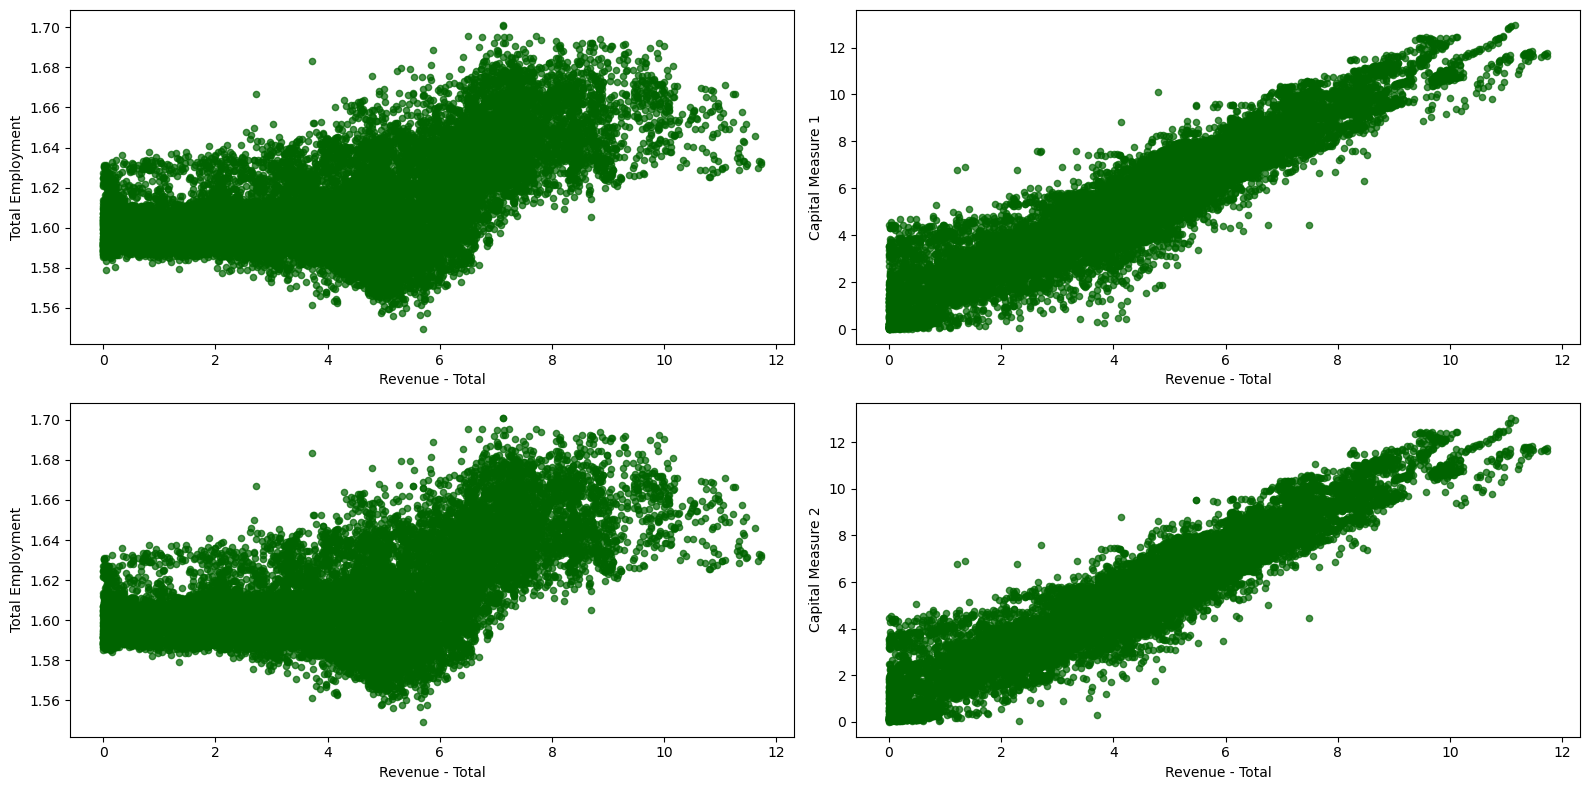

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

# What you want on the y‑axis in each subplot
panels = [(capital1, "Total Employment"),
          (capital1, "Capital Measure 1"),
          (capital2, "Total Employment"),
          (capital2, "Capital Measure 2")]

for ax, (df, y) in zip(axes.flat, panels):
    ax.scatter(df["Revenue - Total"], df[y], alpha=0.7, s=20, color="darkgreen")
    ax.set_xlabel("Revenue - Total")
    ax.set_ylabel(y)

fig.tight_layout()
plt.show()

#### **Simple Linear Regression**

In [28]:
from statsmodels.iolib.summary2 import summary_col
import statsmodels.api as sm

In [29]:
# Add constant term to dataset
capital1['const'] = 1
capital2['const'] = 1

# Create a dataframe of variables to be used in each regression
variables_to_include_ols1 = capital1[['const',
                                      'Total Employment', 
                                      'Capital Measure 1']]
variables_to_include_ols2 = capital2[['const',
                                      'Total Employment',
                                      'Capital Measure 2']]

# Estimate an OLS regression for each set of variables
ols1 = sm.OLS(capital1['Revenue - Total'], variables_to_include_ols1, missing='drop').fit()
ols2 = sm.OLS(capital2['Revenue - Total'], variables_to_include_ols2, missing='drop').fit()

/var/folders/lj/83l4br5s2cz7n6sftfx0dy9c0000gn/T/ipykernel_55493/2295599153.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  capital2['const'] = 1


In [30]:
# Dictionary of functions to be applied to results instances to retrieve model info
info_dict = {'F-stat': lambda x: f"{x.fvalue:.2f}",
             'F p-value': lambda x: f"{x.f_pvalue:.3f}",
             'N Obs': lambda x: f"{int(x.nobs)}",
             'SSR': lambda x: f"{x.ssr:.2f}",
             'ESS': lambda x: f"{x.ess:.2f}",
             'MSE Res': lambda x: f"{x.mse_resid:.2f}"}

ols_results_table = summary_col(results=[ols1, ols2],
                                # show 2 digits
                                float_format='%0.2f',
                                stars = True,
                                model_names=['Model 1', 'Model 2'],
                                info_dict=info_dict,
                                regressor_order=['const', 
                                                 'Capital Measure 1',
                                                 'Capital Measure 2',
                                                 'Total Employment'])

ols_results_table.add_title('Table: OLS Regressions')

print(ols_results_table)

      Table: OLS Regressions
                  Model 1  Model 2 
-----------------------------------
const             -8.89*** -7.75***
                  (0.48)   (0.49)  
Capital Measure 1 0.81***          
                  (0.00)           
Capital Measure 2          0.83*** 
                           (0.00)  
Total Employment  5.46***  4.70*** 
                  (0.30)   (0.31)  
R-squared         0.89     0.89    
R-squared Adj.    0.89     0.89    
F-stat            69080.76 64722.85
F p-value         0.000    0.000   
N Obs             17838    15655   
SSR               11450.05 9433.63 
ESS               88699.51 78018.34
MSE Res           0.64     0.60    
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [31]:
intercept_reg1 = ols1.params['const']
beta_employment_reg1 = ols1.params['Total Employment']
beta_capital1_reg1 = ols1.params['Capital Measure 1']

intercept_reg2 = ols2.params['const']
beta_employment_reg2 = ols2.params['Total Employment']
beta_capital2_reg2 = ols2.params['Capital Measure 2']

In [32]:
financial_data['MPK 2'] = beta_capital2_reg2 * (financial_data['Revenue - Total'] / financial_data['Capital Measure 2'])
financial_data['MPN 2'] = beta_employment_reg1 * (financial_data['Total Employment'] / financial_data['Capital Measure 2'])

In [33]:
MPK_df = financial_data[financial_data['Capital Measure 2'] != financial_data['Capital Measure 2'].min()]

In [34]:
MPK_df[['MPK 2', 'MPN 2']].describe()

,MPK 2,MPN 2
count,15655.000000,15655.000000
mean,0.632907,2.134068
std,0.194327,1.688820
min,0.000372,0.682056
25%,0.574159,1.181420
50%,0.657562,1.579733
75%,0.728151,2.423676
max,3.607342,12.653520


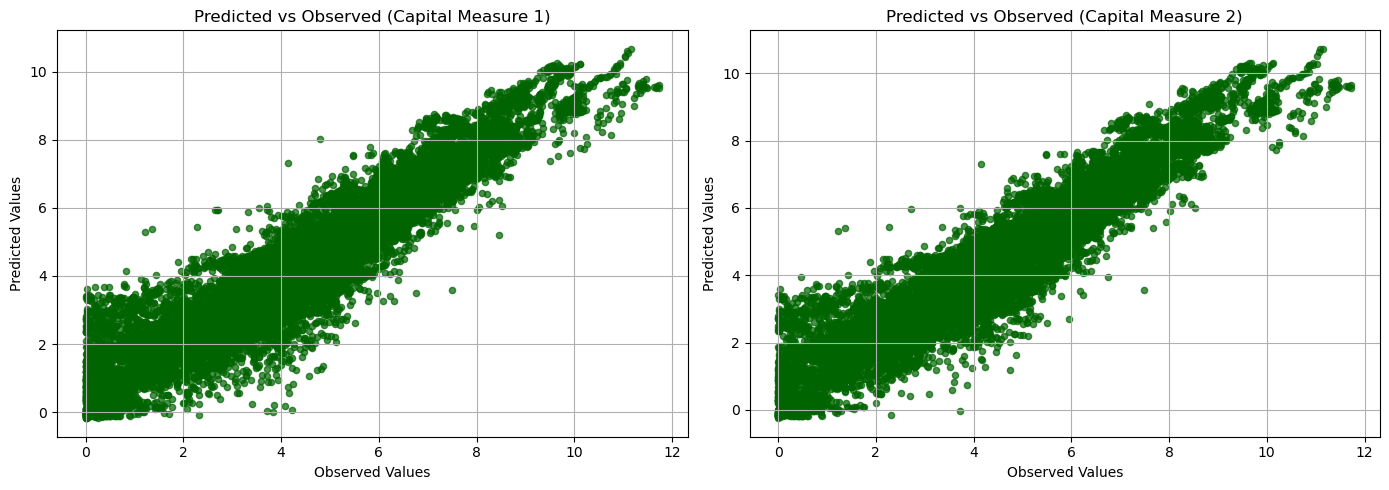

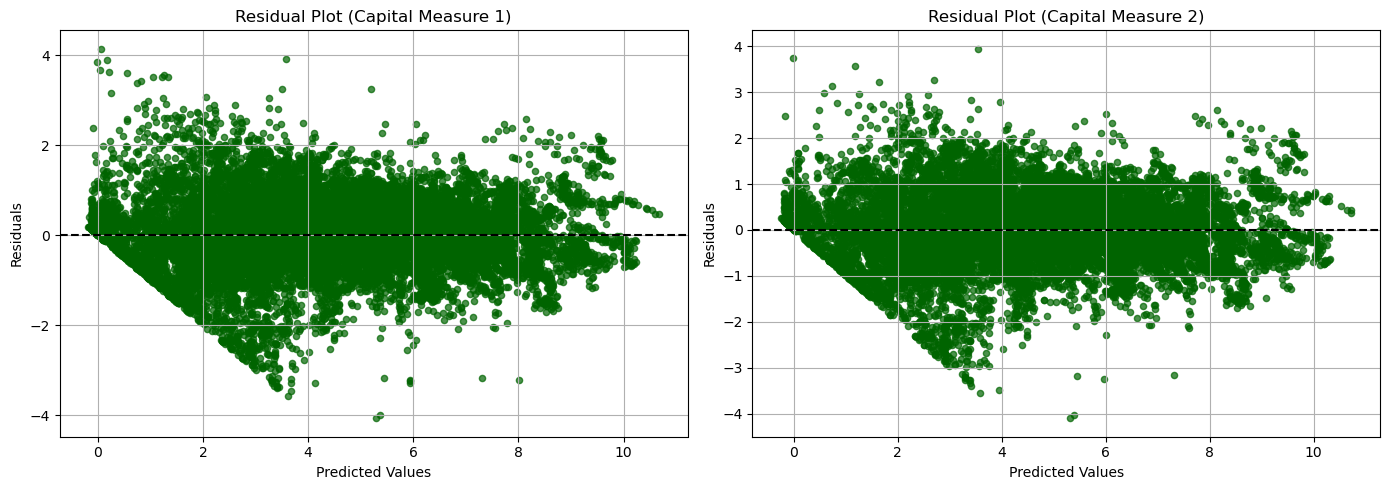

In [35]:
# Actual values
y_actual1 = capital1['Revenue - Total']
y_actual2 = capital2['Revenue - Total']

# Predicted values from each model
pred1 = ols1.predict(variables_to_include_ols1)
pred2 = ols2.predict(variables_to_include_ols2)
import matplotlib.pyplot as plt

# Pair actual and predicted values with model labels
actuals_preds = [(capital1['Revenue - Total'], pred1, 'Capital Measure 1'),
                 (capital2['Revenue - Total'], pred2, 'Capital Measure 2')]

# --- Predicted vs Observed ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for ax, (y_actual, y_pred, label) in zip(axes, actuals_preds):
    ax.scatter(y_actual, y_pred, alpha=0.7, s=20, color='darkgreen')
    ax.set_title(f"Predicted vs Observed ({label})")
    ax.set_xlabel("Observed Values")
    ax.set_ylabel("Predicted Values")
    ax.grid(True)

plt.tight_layout()
plt.show()

# --- Residual Plots ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for ax, (y_actual, y_pred, label) in zip(axes, actuals_preds):
    residuals = y_actual - y_pred
    ax.scatter(y_pred, residuals, alpha=0.7, s=20, color='darkgreen')
    ax.axhline(y=0, color='black', linestyle='--')
    ax.set_title(f"Residual Plot ({label})")
    ax.set_xlabel("Predicted Values")
    ax.set_ylabel("Residuals")
    ax.grid(True)

plt.tight_layout()
plt.show()

#### **Testing for Heteroscedasticity**

In [36]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from statsmodels.formula.api import ols

In [37]:
white_test = het_white(ols2.resid,  ols2.model.exog)
bp_test = het_breuschpagan(ols2.resid, ols2.model.exog)


In [38]:
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
bp_test = dict(zip(labels, bp_test))
white_test = dict(zip(labels, white_test))

test = pd.DataFrame(bp_test, white_test)

test = test.iloc[0:2, :].transpose()

test.rename(columns={'LM Statistic': 'White Test', 'LM-Test p-value': 'BP Test'})

,White Test,BP Test
LM Statistic,3.225394e+02,3.225394e+02
LM-Test p-value,9.151013e-71,9.151013e-71
F-Statistic,1.646307e+02,1.646307e+02
F-Test p-value,1.751720e-71,1.751720e-71


LM-Test p-value at 0.036 indicates that there is heteroscedasticity.

#### **Identifying Heterogeneity**

In [39]:
data = financial_data.dropna()

In [40]:
unit = 'Ticker Symbol'
outcome = 'Revenue - Total'

# Group by unit and compute group means
group_means = data.groupby(unit)[outcome].mean()
overall_mean = data[outcome].mean()

# Between-group variation: how much group means deviate from overall mean
between_var = ((group_means - overall_mean) ** 2 * data.groupby(unit).size()).sum()

# Within-group variation: variation inside each group
within_var = data.groupby(unit).apply(
    lambda group: ((group[outcome] - group[outcome].mean()) ** 2).sum()).sum()

# Total variation
total_var = ((data[outcome] - overall_mean) ** 2).sum()

# Proportions
print(f"Between-unit variation: {between_var / total_var:.2%}")
print(f"Within-unit variation: {within_var / total_var:.2%}")

Between-unit variation: 95.55%
Within-unit variation: 4.45%


Significant between-unit variation, indicating heterogeneity across units.

### **Cluster Analysis**

In [41]:
from sklearn.preprocessing import StandardScaler
from hdbscan import HDBSCAN
import plotly.express as px
import requests
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [42]:
X = capital2
X = X[['Revenue - Total', 'Total Employment', 'Cost of Goods Sold', 'Capital Measure 2']].dropna()

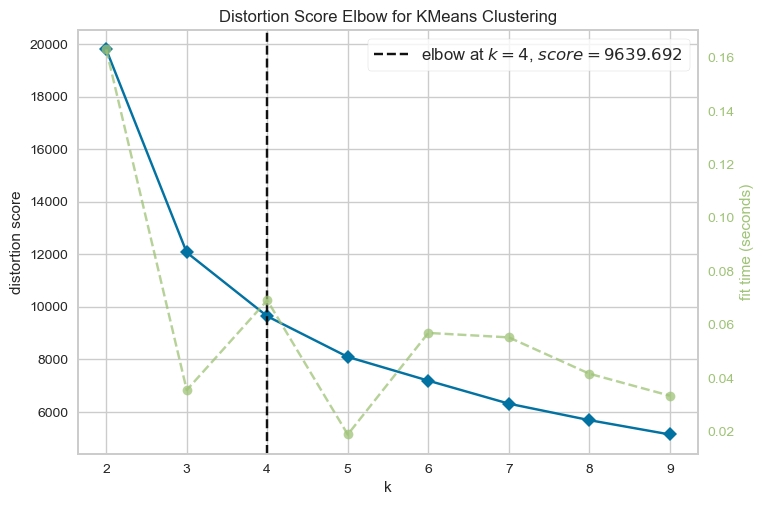

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [43]:
features = ['Revenue - Total', 'Total Employment', 'Capital Measure 2']
X = X[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Instantiate the clustering model and visualizer
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,10))
 
visualizer.fit(X_scaled)
y_kmeans = km.fit_predict(X_scaled)
visualizer.show() 

In [44]:
import plotly.graph_objects as go
Scene = dict(xaxis=dict(title='Revenue - Total -->'), yaxis=dict(title='Total Employment -->'), zaxis=dict(title='Cost of Goods Sold -->'))

labels = y_kmeans.labels_
trace = go.Scatter3d(x=X_scaled[:, 0], y=X_scaled[:, 1], z=X_scaled[:, 2],
                     mode='markers',
                     marker=dict(color=labels, size=5, line=dict(color='black', width=0.5)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 800,width = 800)
trace = [trace]
fig = go.Figure(data = trace, layout = layout)
fig.show()

AttributeError: 'numpy.ndarray' object has no attribute 'labels_'

In [ ]:
# Add Cluster Labels to Original DataFrame
data_with_clusters = capital2.copy()
data_with_clusters['cluster'] = y_kmeans

ValueError: Length of values (6462) does not match length of index (15655)

In [ ]:
cluster_summary = data_with_clusters.groupby('cluster')[features].mean()
cluster_summary

,Revenue - Total,Total Employment,Capital Measure 2
cluster,,,
0,5.785943,1.613060,7.027296
1,1.448808,1.601980,2.140703
2,8.198895,1.650450,9.880959
3,4.757958,1.616167,0.016174
4,3.887823,1.602895,4.637458


In [ ]:
cluster_counts = data_with_clusters['cluster'].value_counts().sort_index()
cluster_counts = pd.DataFrame(cluster_counts).reset_index()

cluster_counts['cluster_label'] = ''

cluster_counts.loc[cluster_counts['cluster'] == 0, 'cluster_label'] = 'Mid-Rev, High-Capital'
cluster_counts.loc[cluster_counts['cluster'] == 1, 'cluster_label'] = 'Small Firms (Low All)'
cluster_counts.loc[cluster_counts['cluster'] == 2, 'cluster_label'] = 'Large Firms'
cluster_counts.loc[cluster_counts['cluster'] == 3, 'cluster_label'] = 'Mid-Rev, Low-Capital'
cluster_counts.loc[cluster_counts['cluster'] == 4, 'cluster_label'] = 'Mid-Small, Mid-Capital'

cluster_counts

,cluster,count,cluster_label
0,0,2113,"Mid-Rev, High-Capital"
1,1,1397,Small Firms (Low All)
2,2,945,Large Firms
3,3,487,"Mid-Rev, Low-Capital"
4,4,2167,"Mid-Small, Mid-Capital"


In [ ]:
summary = data_with_clusters.groupby('cluster').agg({'Revenue - Total': ['mean', 'min', 'max'],
    'Total Employment': ['mean', 'min', 'max'],
    'Capital Measure 2': ['mean', 'min', 'max'],
    'cluster': 'count'}).rename(columns={'count': 'n_obs'})

summary

Revenue - Total                      Total Employment            \
                   mean       min        max             mean       min   
cluster                                                                   
0              5.785943  3.611431   7.659488         1.613060  1.557613   
1              1.448808  0.001998   3.568631         1.601980  1.577622   
2              8.198895  6.120297  11.219896         1.650450  1.572139   
3              4.757958  2.425157   9.774858         1.616167  1.573996   
4              3.887823  1.360207   6.184444         1.602895  1.561345   

                  Capital Measure 2                      cluster  
              max              mean       min        max   n_obs  
cluster                                                           
0        1.688759          7.027296  5.234371   9.042533    2113  
1        1.641030          2.140703  0.000000   5.073385    1397  
2        1.695143          9.880959  7.889090  13.052198     945  
3        1.684540          0.016174  0.000000   2.153157     487  
4        1.662959          4.637458  2.474940   6.914449    2167

In [ ]:
from scipy.stats import f_oneway

for col in features:
    groups = [group[col].values for name, group in data_with_clusters.groupby('cluster')]
    f_stat, p_value = f_oneway(*groups)
    print(f'{col}: F = {f_stat:.2f}, p = {p_value:.4f}')

Revenue - Total: F = 9885.11, p = 0.0000
Total Employment: F = 1259.12, p = 0.0000
Capital Measure 2: F = 16533.67, p = 0.0000


### **Fixed Effects Models**

In [ ]:
from linearmodels.panel import PanelOLS

# Step 1: Drop missing
data = capital1.dropna(subset=['Ticker Symbol', 'time', 'Revenue - Total', 'Capital Measure 1', 'Total Employment'])

# Step 2: Set firm and time index
data = data.set_index(['Ticker Symbol', 'time'])
data['firm_id'] = data.index.get_level_values('Ticker Symbol')
data['time_id'] = data.index.get_level_values('time')

# Step 3: Reset index temporarily
data_reset = data.reset_index()

# Step 4: Create time dummies
time_dummies = pd.get_dummies(data_reset['time'], prefix='quarter', drop_first=True)

# Step 5: Set up X and y
X = pd.concat([data_reset[['Capital Measure 1', 'Total Employment']], time_dummies], axis=1)
X = sm.add_constant(X)

y = data_reset['Revenue - Total']

# Step 6: Set back to MultiIndex
X.index = pd.MultiIndex.from_frame(data_reset[['Ticker Symbol', 'time']])
y.index = pd.MultiIndex.from_frame(data_reset[['Ticker Symbol', 'time']])

# Step 7: Set up cluster IDs
clusters = data_reset[['firm_id', 'time_id']]
clusters.index = X.index  # VERY IMPORTANT: align cluster index with X and y!

# Step 8: Run Fixed Effects model
FE1 = PanelOLS(y, X, entity_effects=True)
FE1_results = FE1.fit(cov_type='clustered', clusters=clusters)

# Step 9: View results
FE1_results.summary

/Users/alexanderperalta/anaconda3/lib/python3.11/site-packages/linearmodels/panel/results.py:88: RuntimeWarning:

invalid value encountered in sqrt



Dep. Variable:,Revenue - Total,R-squared:,0.5634
Estimator:,PanelOLS,R-squared (Between):,0.7575
No. Observations:,17838,R-squared (Within):,0.5634
Date:,"Wed, May 07 2025",R-squared (Overall):,0.7750
Time:,15:04:16,Log-likelihood,-5987.9
Cov. Estimator:,Clustered,,
,,F-statistic:,338.24
Entities:,735,P-value,0.0000
Avg Obs:,24.269,Distribution:,"F(65,17038)"
Min Obs:,1.0000,,
Max Obs:,61.000,F-statistic (robust):,93.895


In [ ]:
# Step 1: Drop missing
data = capital2.dropna(subset=['Ticker Symbol', 'time', 'Revenue - Total', 'Capital Measure 2', 'Total Employment'])

# Step 2: Set firm and time index
data = data.set_index(['Ticker Symbol', 'time'])
data['firm_id'] = data.index.get_level_values('Ticker Symbol')
data['time_id'] = data.index.get_level_values('time')

# Step 3: Reset index temporarily
data_reset = data.reset_index()

# Step 4: Create time dummies
time_dummies = pd.get_dummies(data_reset['time'], prefix='quarter', drop_first=True)

# Step 5: Set up X and y
X = pd.concat([data_reset[['Capital Measure 2', 'Total Employment']], time_dummies], axis=1)
X = sm.add_constant(X)

y = data_reset['Revenue - Total']

# Step 6: Set back to MultiIndex
X.index = pd.MultiIndex.from_frame(data_reset[['Ticker Symbol', 'time']])
y.index = pd.MultiIndex.from_frame(data_reset[['Ticker Symbol', 'time']])

# Step 7: Set up cluster IDs
clusters = data_reset[['firm_id', 'time_id']]
clusters.index = X.index  # VERY IMPORTANT: align cluster index with X and y!

# Step 8: Run Fixed Effects model
FE2 = PanelOLS(y, X, entity_effects=True)
FE2_results = FE2.fit(cov_type='clustered', clusters=clusters)

# Step 9: View results
FE2_results.summary

/Users/alexanderperalta/anaconda3/lib/python3.11/site-packages/linearmodels/panel/results.py:88: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")


Dep. Variable:,Revenue - Total,R-squared:,0.5554
Estimator:,PanelOLS,R-squared (Between):,0.7369
No. Observations:,15655,R-squared (Within):,0.5554
Date:,"Mon, May 05 2025",R-squared (Overall):,0.7601
Time:,22:22:20,Log-likelihood,-3782.6
Cov. Estimator:,Clustered,,
,,F-statistic:,300.22
Entities:,691,P-value,0.0000
Avg Obs:,22.656,Distribution:,"F(62,14902)"
Min Obs:,1.0000,,
Max Obs:,58.000,F-statistic (robust):,51.351


### **Implementing Olley-Pakes**

In [ ]:
df_OP = capital2[['Ticker Symbol', 
                  'time',
                  'Total Employment',
                  'Capital Measure 1',
                  'Capital Measure 2',
                  'Capital Expenditure',
                  'Revenue - Total',
                  'Cost of Goods Sold']]

capital_measure = 'Capital Measure 2'

In [ ]:
df_OP = df_OP.dropna(subset=['Capital Expenditure', capital_measure, 'Revenue -Total']).reset_index(drop=True)

In [ ]:
df_OP['Survival'] = 1

symbols = list(df_OP['Ticker Symbol'].unique())

dfs = {}
for symbol in symbols:
    dfs[symbol] = df_OP[df_OP['Ticker Symbol'] == symbol].copy()

for symbol, df in dfs.items():
    try:

        if df['time'].iloc[-1] != 64.0:
            df.loc[df.index[-1], 'Survival'] = 0

        df['y_next'] = df['Revenue - Total'].shift(-1)
        df['k_next'] = df[capital_measure].shift(-1)        

        dfs[symbol] = df

    except KeyError:
        print(f"Missing required columns in {symbol}, skipping.")

df_OP = pd.DataFrame()

for df in dfs.values():
    df_OP = pd.concat([df_OP, df])


In [ ]:
from sklearn.preprocessing import PolynomialFeatures

y = 'Revenue - Total'
i = 'Capital Expenditure'
k = capital_measure
l = 'Total Employment'

# Create polynomial features of i, k
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(df_OP[[i, k]])

# Names for the polynomial terms
poly_features = poly.get_feature_names_out([i, k])

# Put it into a DataFrame
X_poly_df = pd.DataFrame(X_poly, columns=poly_features)

# Add labor input separately (because it's linear)
X_poly_df[l] = df_OP[l]

# Now regress y on labor + the flexible phi(i,a,k)
X = sm.add_constant(X_poly_df)
y = df_OP[y]

OP_Stage1 = sm.OLS(y, X).fit()

print(OP_Stage1.summary())

                            OLS Regression Results                            
Dep. Variable:        Revenue - Total   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     8009.
Date:                Mon, 05 May 2025   Prob (F-statistic):               0.00
Time:                        22:24:45   Log-Likelihood:                -10478.
No. Observations:                9239   AIC:                         2.098e+04
Df Residuals:                    9228   BIC:                         2.106e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [ ]:
beta_l = OP_Stage1.params['Total Employment']  # save for second stage regression

In [ ]:
df_OP['phi_hat'] = OP_Stage1.predict(X)

In [ ]:
# 4. Estimate a Probit model
OP_probit_model = sm.Probit(df_OP['Survival'], X).fit()

# 5. Review results
OP_probit_model.summary()

Optimization terminated successfully.
         Current function value: 0.237985
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:               Survival   No. Observations:                 9239
Model:                         Probit   Df Residuals:                     9228
Method:                           MLE   Df Model:                           10
Date:                Mon, 05 May 2025   Pseudo R-squ.:                 0.05362
Time:                        22:24:45   Log-Likelihood:                -2198.7
converged:                       True   LL-Null:                       -2323.3
Covariance Type:            nonrobust   LLR p-value:                 8.103e-48
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                     -25.4682      2.029    -12.550      0.000     -29.446     -21.491
Capital Expenditure                         0.2692      0.140      1.920      0.055      -0.006       0.544
Capital Measure 2                           0.1767      0.098      1.806      0.071      -0.015       0.369
Capital Expenditure^2                       0.0070      0.047      0.150      0.881      -0.085       0.098
Capital Expenditure Capital Measure 2      -0.1652      0.078     -2.120      0.034      -0.318      -0.012
Capital Measure 2^2                         0.0487      0.041      1.199      0.230      -0.031       0.128
Capital Expenditure^3                       0.0271      0.007      3.798      0.000       0.013       0.041
Capital Expenditure^2 Capital Measure 2    -0.0698      0.017     -4.032      0.000      -0.104      -0.036
Capital Expenditure Capital Measure 2^2     0.0697      0.016      4.285      0.000       0.038       0.102
Capital Measure 2^3                        -0.0213      0.006     -3.781      0.000      -0.032      -0.010
Total Employment                           16.4952      1.250     13.194      0.000      14.045      18.945
===========================================================================================================
"""

In [ ]:
# 6. Predict survival probabilities
df_OP['survival_prob'] = OP_probit_model.predict(X)

In [ ]:
df_OP = df_OP.dropna(subset=['y_next', 'k_next', 'phi_hat', 'survival_prob']).reset_index(drop=True)

# Step 2: Create polynomial terms for (phi_hat, survival_prob)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(df_OP[['phi_hat', 'survival_prob']])

poly_features = poly.get_feature_names_out(['phi_hat', 'survival_prob'])
X_poly_df = pd.DataFrame(X_poly, columns=poly_features)

# Step 3: Set up final regression variables
X_poly_df['k_next'] = df_OP[['k_next']]

X = sm.add_constant(X_poly_df)  # add constant
y = df_OP['y_next']

# Step 4: Final regression
OP_Stage2 = sm.OLS(y, X).fit()

print(OP_Stage2.summary())

                            OLS Regression Results                            
Dep. Variable:                 y_next   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                 1.245e+04
Date:                Mon, 05 May 2025   Prob (F-statistic):               0.00
Time:                        22:24:47   Log-Likelihood:                -9698.2
No. Observations:                8584   AIC:                         1.941e+04
Df Residuals:                    8577   BIC:                         1.946e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.55

In [ ]:
beta_k = OP_Stage2.params['k_next']  # from second stage regression

# Make sure time periods are correcly aligned 
# Compute TFP for today's output

# Estimate TFP
df_OP['TFP_hat'] = np.exp(df_OP['Revenue - Total'] - (beta_l * df_OP['Total Employment']) - (beta_k * df_OP[capital_measure]))

df_OP

,Ticker Symbol,time,Total Employment,Capital Measure 1,Capital Measure 2,Capital Expenditure,Revenue - Total,Cost of Goods Sold,Survival,y_next,k_next,phi_hat,survival_prob,TFP_hat
0,BKTI,20.0,1.625548,3.008969,3.017934,1.012691,1.859262,1.566530,1,2.073046,3.068042,2.247146,0.975464,0.001157
1,BKTI,24.0,1.629100,3.222539,3.068042,1.942046,2.073046,1.792759,1,2.343919,3.184314,2.675271,0.978358,0.001382
2,BKTI,32.0,1.631546,3.188322,3.184314,1.047319,2.343919,2.197780,1,2.123100,3.419692,2.406316,0.981274,0.001714
3,BKTI,40.0,1.620723,3.401524,3.419692,2.267062,2.123100,1.891152,1,2.627418,3.557717,2.976484,0.970799,0.001320
4,BKTI,48.0,1.617457,3.546639,3.557717,2.435191,2.627418,2.285235,1,3.060536,3.728996,3.100301,0.966648,0.002105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8579,UCTT,58.0,1.593982,7.349016,7.343491,3.421000,6.248430,6.030685,1,6.294158,7.404266,5.816503,0.871819,0.020585
8580,VISL,17.0,1.602990,3.257509,3.222390,1.191191,0.223144,1.857703,1,2.715555,3.452651,2.372098,0.947662,0.000231
8581,VISL,32.0,1.600549,3.463537,3.452651,3.019839,2.715555,2.420724,1,2.488401,3.165939,3.063737,0.928154,0.002586
8582,VISL,48.0,1.588363,3.180173,3.165939,2.563179,2.488401,2.004718,1,2.205193,3.248318,2.722157,0.902604,0.002432


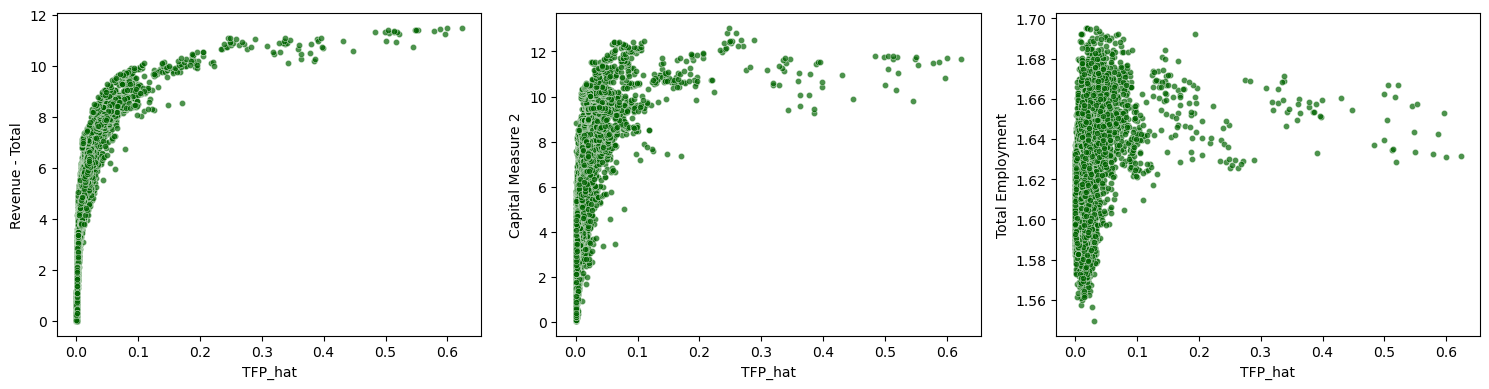

In [ ]:
import seaborn as sns

pair_plot_df = df_OP[['Revenue - Total',
                      'Capital Measure 2',
                      'Total Employment',
                      'TFP_hat']]

pair_plot_df = pair_plot_df.reset_index()
pair_plot_df.drop(columns={'index'}, inplace=True)

main_var = 'TFP_hat'
other_vars = [col for col in pair_plot_df.columns if col != main_var]

fig, axes = plt.subplots(1, len(other_vars), figsize=(5 * len(other_vars), 4))
if len(other_vars) == 1:
    axes = [axes]  # make iterable

for ax, var in zip(axes, other_vars):
    
    sns.scatterplot(x=pair_plot_df[main_var], y=pair_plot_df[var], alpha=0.7, s=20, color='darkgreen', ax=ax)
    ax.set_xlabel(main_var)
    ax.set_ylabel(var)

plt.tight_layout()
plt.show()

In [ ]:
df_OP.dropna(subset='time', inplace=True)

In [ ]:
# Invert the quarter_map dictionary
inv_quarter_map = {v: k for k, v in quarter_map.items()}

# Map the 'time' column to actual quarter-year labels
df_OP['quarter_label'] = df_OP['time'].map(inv_quarter_map)

# Split into year and quarter
df_OP['quarter'] = df_OP['quarter_label'].str[-1].astype(int)
df_OP['year'] = df_OP['quarter_label'].str[:4].astype(int)

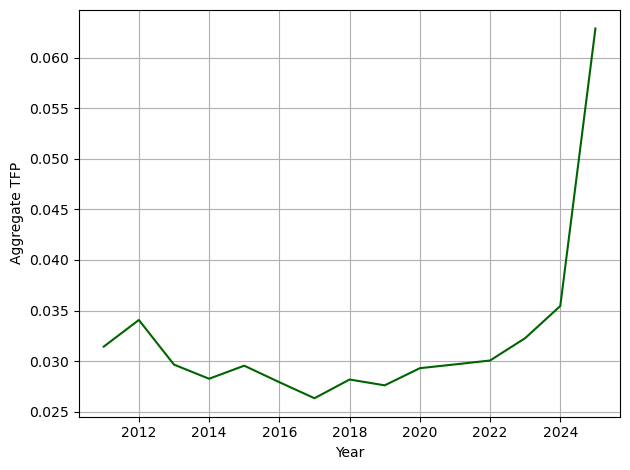

In [ ]:
OP_TFP_df = df_OP

# Step 1: Compute total output by year
OP_TFP_df['year_output'] = df_OP.groupby('year')['Revenue - Total'].transform('sum')

# Step 2: Compute output share for each firm-year
OP_TFP_df['output_share'] = OP_TFP_df['Revenue - Total'] / OP_TFP_df['year_output']

# Step 3: Compute weighted TFP
OP_TFP_df['weighted_TFP'] = OP_TFP_df['TFP_hat'] * OP_TFP_df['output_share']

# Step 4: Aggregate to industry-level TFP by year
aggregate_TFP = OP_TFP_df.groupby('year')['weighted_TFP'].sum().reset_index(name='aggregate_TFP')

plt.plot(aggregate_TFP['year'][1:16], aggregate_TFP['aggregate_TFP'][1:16], color='darkgreen')
plt.xlabel('Year')
plt.ylabel('Aggregate TFP')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Step 1: Build the grid
phi_vals = np.linspace(df_OP['phi_hat'].min(), df_OP['phi_hat'].max(), 50)
surv_vals = np.linspace(df_OP['survival_prob'].min(), df_OP['survival_prob'].max(), 50)
phi_grid, surv_grid = np.meshgrid(phi_vals, surv_vals)

phi_flat = phi_grid.ravel()
surv_flat = surv_grid.ravel()

poly_input = np.vstack([phi_flat, surv_flat]).T

# Step 2: Match model columns
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(poly_input)
poly_features_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(['phi_hat', 'survival_prob']))

original_columns = OP_Stage2.model.exog_names

X_pred = pd.DataFrame(0, index=np.arange(poly_features_df.shape[0]), columns=original_columns)
X_pred['const'] = 1
for col in poly_features_df.columns:
    if col in X_pred.columns:
        X_pred[col] = poly_features_df[col]

# Step 3: Predict
g_values = OP_Stage2.predict(X_pred)
g_surface = g_values.values.reshape(phi_grid.shape)

# Step 4: Interactive Plotly surface
fig = go.Figure(data=[go.Surface(z=g_surface, x=phi_vals, y=surv_vals, colorscale='algae')])

# Surface
fig.add_trace(go.Surface(
    z=g_surface, x=phi_vals, y=surv_vals, colorscale='algae', 
    contours = {
        "z": {"show": True, "start": np.min(g_surface), "end": np.max(g_surface), "size": 0.5, "color":"white"},
        "x": {"show": True, "start": phi_vals.min(), "end": phi_vals.max(), "size": 1},
        "y": {"show": True, "start": surv_vals.min(), "end": surv_vals.max(), "size": 0.01},}))

# Layout
fig.update_layout(
    title='Selection Correction Surface g(phi_hat, survival_prob) with Contours',
    scene=dict(
        xaxis_title='phi_hat',
        yaxis_title='survival_prob',
        zaxis_title='g(phi_hat, survival_prob)',),
    autosize=True,
    width=950,
    height=750,
    margin=dict(l=65, r=50, b=65, t=90),)

fig.show()

In [ ]:
# Instead of nonparametric regression, use a parametric approach
# Create polynomial features to approximate the g function
from sklearn.preprocessing import PolynomialFeatures
df_OP['index2'] = df_OP['phi_hat'] - beta_k * df_OP[capital_measure]

# Create polynomial features (degree 2) to approximate the g function
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(df_OP[['survival_prob', 'index2']].values)

# Add the labor variable to test its significance
X_full = np.column_stack([X_poly, df_OP['Total Employment'].values])
X_full = sm.add_constant(X_full)

# Run regression
model = sm.OLS(y_g, X_full).fit()

# The coefficient and p-value for the labor term will be the last one
l_t_coefficient = model.params[-1]
p_value = model.pvalues[-1]
print(f"Labor coefficient: {l_t_coefficient}, p-value: {p_value}")

In [ ]:
# Implement the robustness test described in section 4.1
beta_k = df_OP['k_next']
            
# Create dependent variable: y_next - beta_l * l_next
df_OP['y_minus_bl'] = df_OP['y_next'] - beta_l * df_OP['Total Employment']
            
# Create index variables for g function
df_OP['index2'] = df_OP['phi_hat'] - beta_k * df_OP['Capital Measure 2']
            
X_g = df_OP[['survival_prob', 'index2', 'Total Employment']].values
y_g = df_OP['y_minus_bl'] - beta_k * df_OP['k_next']
            

### **Implementing D. A. ACKERBERG, K. CAVES, AND G. FRAZER**

In [45]:
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf

# For the copula part, install via: pip install copulas
from copulas.multivariate import GaussianMultivariate


In [46]:
financial_data_COPULA = capital2[['Ticker Symbol',
                                  'time',
                                  'Total Employment',
                                  'Capital Measure 1',
                                  'Capital Measure 2', 
                                  'Revenue - Total',
                                  'Inventory - Raw Materials',
                                  'Cost of Goods Sold']]

In [47]:
financial_data_COPULA = financial_data_COPULA.dropna()

#### Step 2: Transform Materials into a Uniform Variable

Use the empirical CDF to map log_materials to U(0, 1)


In [57]:
capital_measure = 'Capital Measure 2'
material_input = 'Inventory - Raw Materials'
#material_input = 'Cost of Goods Sold'

ecdf_materials = ECDF(financial_data_COPULA[material_input])
financial_data_COPULA['u_materials'] = ecdf_materials(financial_data_COPULA[material_input])

#### Step 3: First Stage Regression for the Production Function

Regress log_output on log_capital and log_labor to obtain residuals

In [58]:
X_first = financial_data_COPULA[[capital_measure, material_input]]
y_first = financial_data_COPULA['Revenue - Total']
lin_reg = LinearRegression().fit(X_first, y_first)
financial_data_COPULA['resid'] = y_first - lin_reg.predict(X_first)

In [ ]:
y = 'Revenue - Total'
i = 'Capital Expenditure'
m = material_input
l = 'Total Employment'

# Create polynomial features of k, l, m
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(df_OP[[k, l, m]])

# Names for the polynomial terms
poly_features = poly.get_feature_names_out([i, k])

# Put it into a DataFrame
X_poly_df = pd.DataFrame(X_poly, columns=poly_features)

# Add labor input separately (because it's linear)
X_poly_df[l] = df_OP[l]

# Now regress y on labor + the flexible phi(i,a,k)
X = sm.add_constant(X_poly_df)
y = df_OP[y]

OP_Stage1 = sm.OLS(y, X).fit()

print(OP_Stage1.summary())

In [59]:
X = financial_data_COPULA[[capital_measure, material_input]]
X = sm.add_constant(X)  # Adds intercept
y = financial_data_COPULA['Revenue - Total']

ACF_stage1 = sm.OLS(y, X).fit()

print(ACF_stage1.summary())

t_stat = ACF_stage1.tvalues[material_input]
f_stat = t_stat ** 2

print(f"F-statistic for {material_input}: {f_stat:.2f}")

                            OLS Regression Results                            
Dep. Variable:        Revenue - Total   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                 5.468e+04
Date:                Wed, 07 May 2025   Prob (F-statistic):               0.00
Time:                        15:42:54   Log-Likelihood:                -16289.
No. Observations:               13984   AIC:                         3.258e+04
Df Residuals:                   13981   BIC:                         3.261e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

#### Step 4: Transform Residuals to Uniform Scale

 Use the empirical CDF for the residuals


In [60]:
ecdf_resid = ECDF(financial_data_COPULA['resid'])
financial_data_COPULA['u_resid'] = ecdf_resid(financial_data_COPULA['resid'])

#### Step 5: Fit a Gaussian Copula to ($u_{materials}$, $u_{resid}$)

Prepare data for the copula model using the uniformized variables.

In [61]:
copula_data = financial_data_COPULA[['u_materials', 'u_resid']]
gaussian_copula = GaussianMultivariate()
gaussian_copula.fit(copula_data)

/Users/alexanderperalta/anaconda3/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:5999: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/Users/alexanderperalta/anaconda3/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:5990: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Users/alexanderperalta/anaconda3/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:5999: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)


#### Step 6: Construct a Control Function Term

One practical approach is to capture the conditional relationship between $u_{materials}$ and $u_{resid}$.

Here we use a simple nonparametric regression (for example, using a spline or polynomial).

For illustration, we use an OLS regression of $u_{materials}$ on $u_{resid}$.

In [62]:
# Spline regression
from patsy import dmatrices
y_spline, X_spline = dmatrices('u_resid ~ bs(u_materials, df=5)', data=financial_data_COPULA)
spline_model = sm.OLS(y_spline, X_spline).fit()
financial_data_COPULA['control_term'] = spline_model.predict(X_spline)

#### Step 7: Estimate the Production Function Including the Control Term

Now, add the control term into your production function regression.

Typically, the control function helps control for the unobserved productivity shock.

In [63]:
X_final = financial_data_COPULA[[capital_measure, 'Total Employment', 'control_term']]
X_final = sm.add_constant(X_final)  # add intercept
clusters = financial_data_COPULA['Ticker Symbol']
y_final = financial_data_COPULA['Revenue - Total']
production_model = sm.OLS(y_final, X_final).fit(cov_type='cluster', cov_kwds={'groups': clusters})

# Display the results
print(production_model.summary())

                            OLS Regression Results                            
Dep. Variable:        Revenue - Total   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     1952.
Date:                Wed, 07 May 2025   Prob (F-statistic):               0.00
Time:                        15:43:03   Log-Likelihood:                -15707.
No. Observations:               13984   AIC:                         3.142e+04
Df Residuals:                   13980   BIC:                         3.145e+04
Df Model:                           3                                         
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -10.0693      1.89

In [56]:
beta_l = production_model.params['Total Employment']  # from first stage regression
beta_k = production_model.params[capital_measure]  # from second stage regression
gamma = production_model.params['control_term']  # Get coefficient from regression

financial_data_COPULA['TFP_hat'] = financial_data_COPULA['Revenue - Total'] - (beta_l * financial_data_COPULA['Total Employment']) - (beta_k * financial_data_COPULA[capital_measure]) - (gamma * financial_data_COPULA['control_term'])

financial_data_COPULA.where(financial_data_COPULA['TFP_hat']<0).dropna()
financial_data_COPULA

,Ticker Symbol,time,Total Employment,Capital Measure 1,Capital Measure 2,Revenue - Total,Inventory - Raw Materials,Cost of Goods Sold,u_materials,resid,u_resid,control_term,TFP_hat
3,BKTI,16.0,1.626971,2.993279,2.993279,1.968370,1.469716,1.663926,0.181136,-0.107646,0.438072,0.494546,-11.810328
4,BKTI,20.0,1.625548,3.008969,3.017934,1.859262,1.640743,1.566530,0.166047,-0.158285,0.377074,0.477045,-11.910147
5,BKTI,24.0,1.629100,3.222539,3.068042,2.073046,1.750243,1.792759,0.197869,-0.117051,0.425772,0.512777,-11.801398
6,BKTI,28.0,1.629748,3.182834,3.182834,2.107300,1.819861,1.787751,0.197225,-0.118636,0.424128,0.512099,-11.864140
7,BKTI,32.0,1.631546,3.188322,3.184314,2.343919,1.859730,2.197780,0.254505,-0.164186,0.370137,0.565102,-11.701016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,VISL,48.0,1.588363,3.180173,3.165939,2.488401,2.588365,2.004718,0.226044,0.119204,0.662829,0.540635,-11.227630
14,VISL,52.0,1.593834,3.102926,3.102926,2.126087,2.641768,2.251818,0.264803,-0.391291,0.157180,0.573031,-11.611785
15,VISL,56.0,1.594206,3.198019,3.248318,2.205193,2.700690,1.857859,0.206236,-0.091309,0.457666,0.521423,-11.594742
3,SVRE,56.0,1.597759,1.153568,1.152153,0.306013,0.991398,0.821980,0.029248,-0.561667,0.085026,0.274190,-11.528953
